<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Probability_Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyod --quiet

     |████████████████████████████████| 134 kB 35.3 MB/s 


In [ ]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [ ]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns
import timeit

Data Pre-processing

In [ ]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [ ]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [ ]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [ ]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)

train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# trim start stage
train_df = train_df.iloc[21600:]

In [ ]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [ ]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [ ]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [ ]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

Model Prediction using ECOD

In [ ]:
from  pyod.models.ecod import ECOD
start = timeit.default_timer()
model = ECOD(contamination=0.0000001)
model.fit(train_scale)
end = timeit.default_timer()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print(f'total training time {end-start}')

total training time 10.755969042999823


In [ ]:
# get outlier scores
train_scores = model.decision_scores_  # raw outlier scores on the train data

start = timeit.default_timer()
test_scores = model.decision_function(test_scale)  # predict raw outlier scores on test
end = timeit.default_timer()

In [ ]:
print(f'total prediction time {end-start}')

total prediction time 19.36354768199999


In [ ]:
pd.DataFrame(test_scores).describe()

,0
count,449919.000000
mean,47.068428
std,15.869197
min,24.412061
25%,36.899770
50%,43.259053
75%,51.311999
max,111.768931


In [ ]:
pd.DataFrame(train_scores).describe()

,0
count,475200.000000
mean,44.071568
std,9.694732
min,24.888813
25%,36.508637
50%,43.094663
75%,50.165837
max,98.871578


In [ ]:
fpr, tpr, _ = metrics.roc_curve(label,  test_scores)
auc = metrics.roc_auc_score(label,  test_scores)

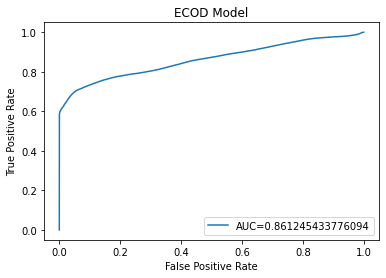

In [ ]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ECOD Model')
plt.show()

In [ ]:
np.any(np.isnan(test_scores)),np.all(np.isfinite(test_scores))

(False, True)

In [ ]:
#normalise error score
min_train = min(train_scores)
max_train = max(train_scores)
norm_train = (train_scores-min_train)/(max_train-min_train)

In [ ]:
norm_test = (test_scores - min_train)/(max_train-min_train)

In [ ]:
df_error_train = pd.DataFrame(norm_train,columns = ['error'])
df_error_train['type'] = 'train'
df_error_test = pd.DataFrame(norm_test,columns = ['error'])
df_error_test['type'] = 'test'

pd.concat([df_error_train,df_error_test]).to_csv("/content/drive/MyDrive/Data_sci_Project/ECOD/error.csv")

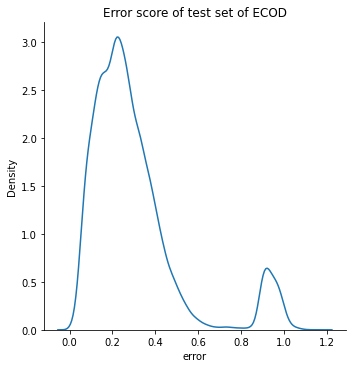

In [ ]:
# sns.displot(df_error_train, x="error",kind="kde")
sns.displot(df_error_test, x="error",kind="kde")
plt.title("Error score of test set of ECOD")
plt.show()

In [ ]:
threshold= np.percentile(norm_test,90)
threshold

0.5971578814105468

In [ ]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    pred_label[i:i+time_window] = 0
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
  return pred_label

In [ ]:
time_window = 10
pred_label = pred_labels_timewindow(norm_test,threshold,time_window)

In [ ]:
print(metrics.classification_report(label,pred_label))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    395298
           1       0.89      0.62      0.73     54621

    accuracy                           0.94    449919
   macro avg       0.92      0.80      0.85    449919
weighted avg       0.94      0.94      0.94    449919



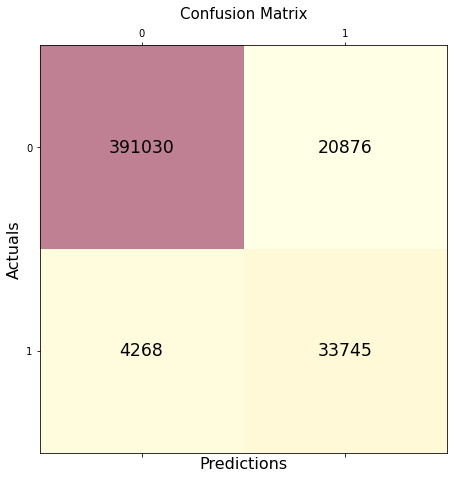

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label,pred_label)

# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(cm, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(cm.shape[0]):
    for n in range(cm.shape[1]):
        px.text(x=m,y=n,s=cm[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [ ]:
time_label = pd.DataFrame(pred_label, index= test_df.index, columns = ['pred'])

In [ ]:
time_label['label'] = label
time_label.reset_index(inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label.Timestamp)

true anomaly

In [ ]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [ ]:
start_time = true_anomaly['Start Time'][~true_anomaly["End Time"].isnull()]
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [ ]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [ ]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [ ]:
len(start_time) #there are 36 attack

36

In [ ]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [ ]:
time_label['attack #'] = 0
for i in range (len(idx_start)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = attack_lenght.index.values[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0, 0.5, 'normal/attack')

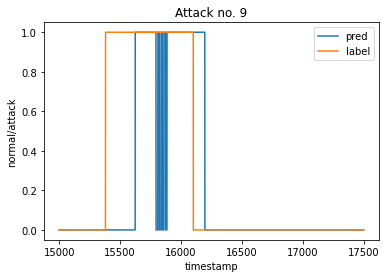

In [ ]:
plt.plot(time_label.loc[15000:17500].index,time_label.loc[15000:17500]["pred"])
plt.plot(time_label.loc[15000:17500].index,time_label.loc[15000:17500]["label"])
plt.title('Attack no. 9')
plt.legend(["pred", "label"])
plt.xlabel("timestamp")
plt.ylabel("normal/attack")

Text(0.5, 1.0, 'attack 1-8')

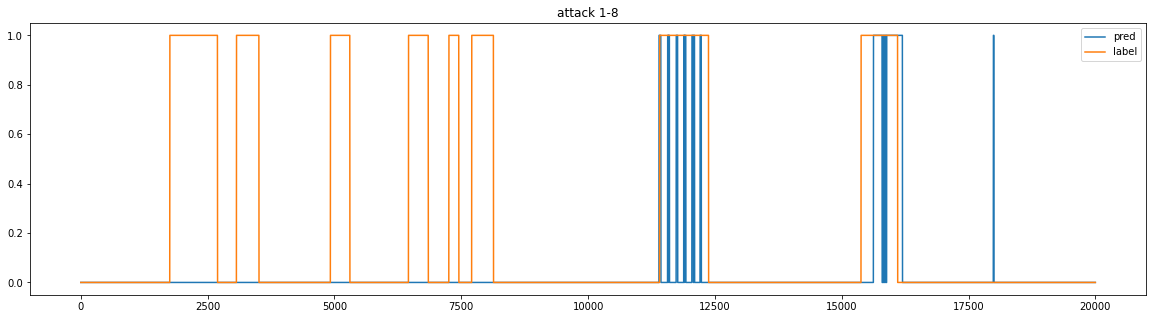

In [ ]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[:20000],time_label["pred"][:20000])
plt.plot(time_label.index[:20000],time_label["label"][:20000])
plt.legend(["pred", "label"])
plt.title('attack 1-8')

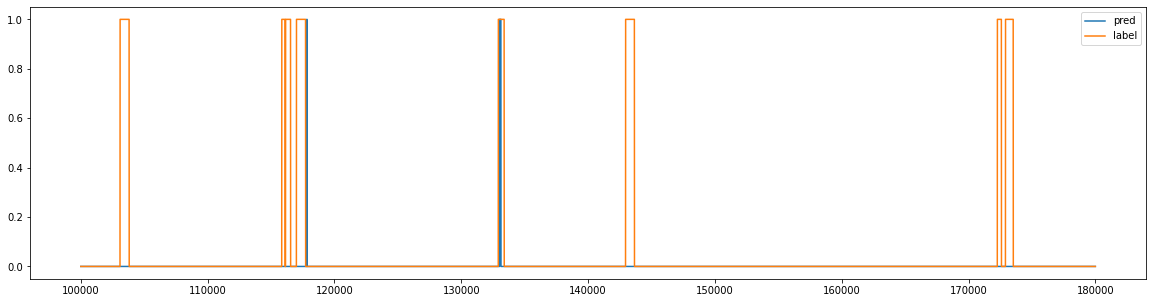

In [ ]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[100000:180000],time_label["pred"][100000:180000])
plt.plot(time_label.index[100000:180000],time_label["label"][100000:180000])
plt.legend(["pred", "label"])

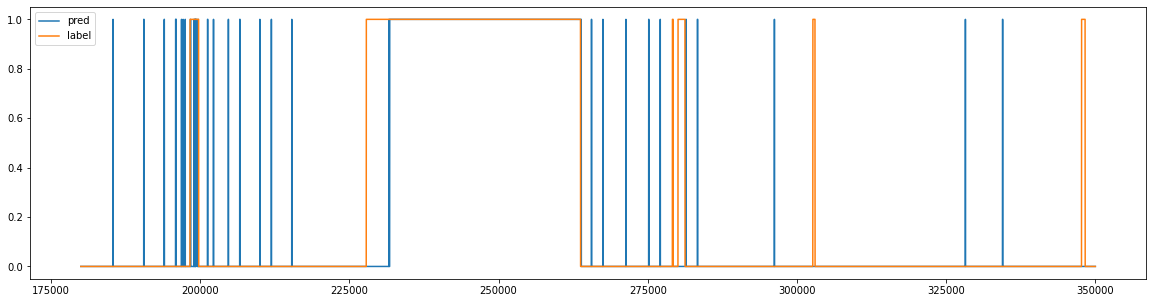

In [ ]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[180000:350000],time_label["pred"][180000:350000])
plt.plot(time_label.index[180000:350000],time_label["label"][180000:350000])
plt.legend(["pred", "label"])

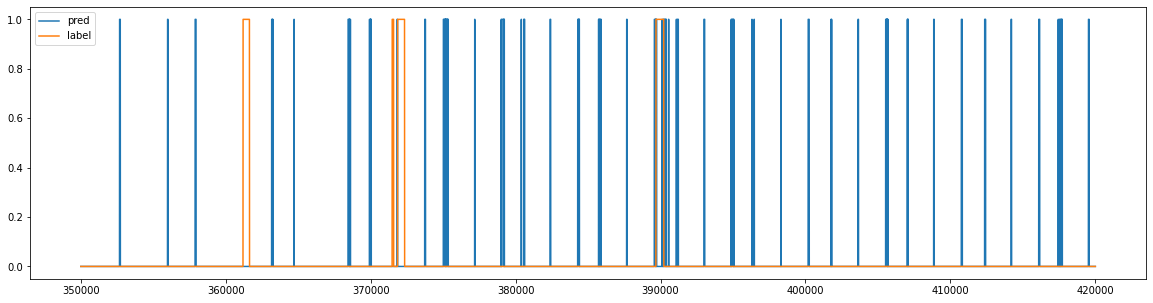

In [ ]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[350000:420000],time_label["pred"][350000:420000])
plt.plot(time_label.index[350000:420000],time_label["label"][350000:420000])
plt.legend(["pred", "label"])

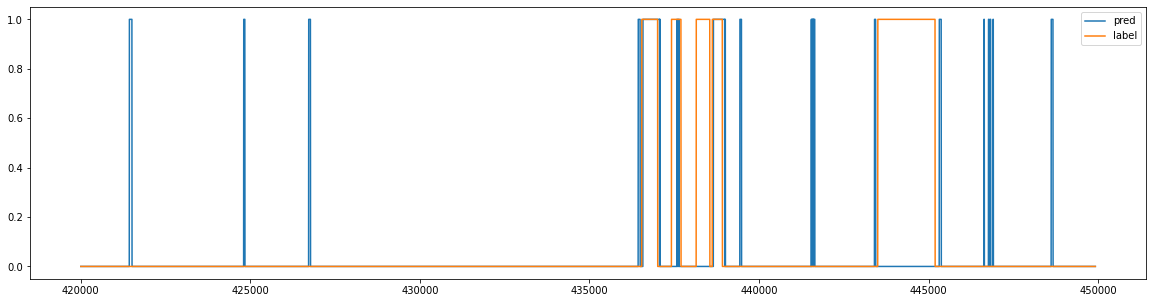

In [ ]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[420000:],time_label["pred"][420000:])
plt.plot(time_label.index[420000:],time_label["label"][420000:])
plt.legend(["pred", "label"])

In [ ]:
found = []
for i in range(len(time_label)):
  if (time_label.loc[i]["pred"] == 1) & (time_label.loc[i]["label"] == 1):
    found.append(time_label.loc[i]["attack #"])

In [ ]:
np.unique(found)

array([ 7, 10, 21, 25, 27, 35, 36, 37, 39])

In [ ]:
print(f"There are {len(np.unique(found))} attacks found")

There are 9 attacks found


Apply XAI

##CASE STUDY attack no.10
model cannot detect the anomaly point

### SHAP

In [ ]:
!pip install shap --quiet

     |████████████████████████████████| 569 kB 9.0 MB/s 


In [ ]:
import shap

In [ ]:
#summarize all the train data using shap.kmeans
X_train_summary = shap.kmeans(train_scale, 50)

In [ ]:
shap_explainer = shap.KernelExplainer(model=model.decision_function, data=X_train_summary)

In [ ]:
#attack no.1
#sample data  in attack no.1 for 100 instance
sample = shap.sample(test_scale[idx_start[7]:idx_end[7]], 100)

In [ ]:
np.any(np.isnan(sample)), np.all(np.isfinite(sample))

(False, True)

In [ ]:
start = timeit.default_timer()
shap_values_1 = shap_explainer.shap_values(X=sample, nsamples=100)
end = timeit.default_timer()

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
print(end-start)

1369.2168692660002


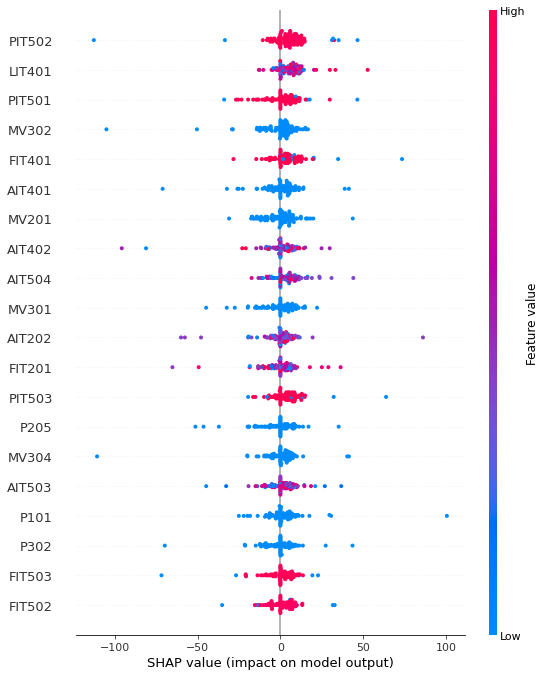

In [ ]:
shap.initjs()
shap.summary_plot(shap_values_1, sample)

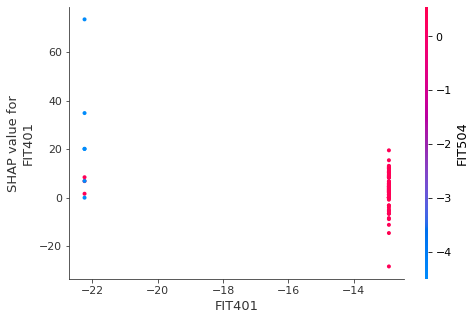

In [ ]:
shap.dependence_plot("FIT401", shap_values_1, sample)

In [ ]:
shap_result = pd.DataFrame(np.mean(shap_values_1,axis=0), index = train_scale.columns, columns = ['result'])

In [ ]:
shap_result.sort_values(by=['result'], ascending=False)

,result
LIT401,6.084233
FIT401,4.733223
PIT502,4.549090
AIT504,4.243583
PIT503,3.969367
FIT501,3.399448
P101,2.247834
UV401,1.907964
PIT501,1.842910
AIT501,1.666174


### LIME

In [ ]:
!pip install lime --quiet

     |████████████████████████████████| 275 kB 7.8 MB/s 


In [ ]:
import lime
import lime.lime_tabular
from lime import submodular_pick

In [ ]:
lime = lime.lime_tabular.LimeTabularExplainer(X_train_summary.data, feature_names=train_scale.columns,
                                                   verbose=True, mode='regression')

In [ ]:
start = timeit.default_timer()
a = lime.explain_instance(sample.iloc[10], model.decision_function, num_features=10)
end = timeit.default_timer()

Intercept 73.29727297999177
Prediction_local [61.2256502]
Right: 75.10453056801474


In [ ]:
print(end-start)

47.66871186900016


In [ ]:
a.show_in_notebook(show_table=False)

In [ ]:
start = timeit.default_timer()
sp_obj = submodular_pick.SubmodularPick(lime, sample.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()

Requested sample size larger than
                              size of input data. Using all data


Intercept 74.65109530365318
Prediction_local [61.26261437]
Right: 72.624129175779
Intercept 72.83889726930101
Prediction_local [65.19352218]
Right: 170.02957152591569
Intercept 74.39380011973823
Prediction_local [60.33728556]
Right: 74.4334037949368
Intercept 73.99327837803281
Prediction_local [62.47420478]
Right: 73.87080632087643
Intercept 74.8616881272627
Prediction_local [61.94204945]
Right: 74.4338117011153
Intercept 74.5122872935793
Prediction_local [60.28521863]
Right: 75.06948085883599
Intercept 74.51929738321414
Prediction_local [61.82754615]
Right: 73.49187359731786
Intercept 74.30457310775958
Prediction_local [62.77628946]
Right: 78.22283512430167
Intercept 72.54756114326806
Prediction_local [64.63732817]
Right: 171.13590544021932
Intercept 73.57871404094266
Prediction_local [60.97127026]
Right: 73.99049309821754
Intercept 74.29990729406498
Prediction_local [61.92372181]
Right: 75.34181425523605
Intercept 73.8837917741771
Prediction_local [62.68938637]
Right: 83.26628565002


In [ ]:
print(end-start)

3527.5946517259995


[<Figure size 432x288 with 1 Axes>]

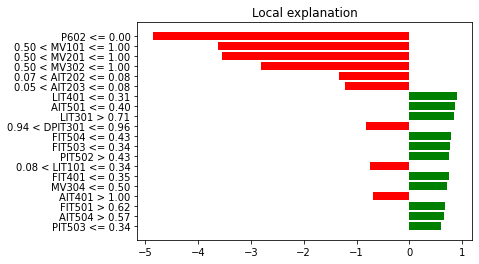

In [ ]:
[exp.as_pyplot_figure(label=0) for exp in sp_obj.sp_explanations]

In [ ]:
sp_obj.sp_explanations[0].as_list()

[('P602 <= 0.00', -4.853452819884916),
 ('0.50 < MV101 <= 1.00', -3.610532573910558),
 ('0.50 < MV201 <= 1.00', -3.547525177580875),
 ('0.50 < MV302 <= 1.00', -2.805670551051741),
 ('0.07 < AIT202 <= 0.08', -1.3324740705027285),
 ('0.05 < AIT203 <= 0.08', -1.2159864325681733),
 ('LIT401 <= 0.31', 0.9000597208314258),
 ('AIT501 <= 0.40', 0.8525224787698401),
 ('LIT301 > 0.71', 0.8362499298072986),
 ('0.94 < DPIT301 <= 0.96', -0.8131521464189508),
 ('FIT504 <= 0.43', 0.7819644696282073),
 ('FIT503 <= 0.34', 0.7621580775335165),
 ('PIT502 > 0.43', 0.7562613362993086),
 ('0.08 < LIT101 <= 0.34', -0.7534963788651018),
 ('FIT401 <= 0.35', 0.7402360659164701),
 ('MV304 <= 0.50', 0.7024838486277699),
 ('AIT401 > 1.00', -0.6833978870444604),
 ('FIT501 > 0.62', 0.6684932462885961),
 ('AIT504 > 0.57', 0.6583917013666295),
 ('PIT503 <= 0.34', 0.6007857511190418)]

###ALE

In [ ]:
!pip install alibi[tensorflow] --quiet

     |████████████████████████████████| 445 kB 7.1 MB/s 
     |████████████████████████████████| 4.7 MB 42.1 MB/s 
     |████████████████████████████████| 60 kB 6.8 MB/s 
     |████████████████████████████████| 98.5 MB 103 kB/s 
     |████████████████████████████████| 6.6 MB 37.7 MB/s 
     |████████████████████████████████| 101 kB 10.9 MB/s 
     |████████████████████████████████| 596 kB 51.3 MB/s 


In [ ]:
from alibi.explainers import ALE

In [ ]:
ale = ALE(model.decision_function, feature_names=train_scale.columns)

In [ ]:
start = timeit.default_timer()
exp_ale = ale.explain(sample.to_numpy())
end = timeit.default_timer()

In [ ]:
print(end-start)

854.8487124780004


In [ ]:
exp_ale.feature_names

array(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204',
       'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401',
       'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501',
       'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503',
       'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601',
       'P601', 'P602', 'P603'], dtype=object)

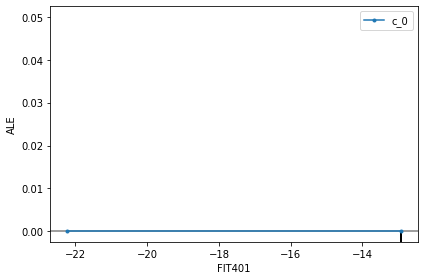

In [ ]:
from alibi.explainers import plot_ale
plot_ale(exp_ale, features = ['FIT401']);

In [ ]:
mean_ale = []
for e in exp_ale.ale_values:
  mean_ale.append(np.mean(e))

In [ ]:
ale_result = pd.DataFrame(mean_ale, index = train_scale.columns, columns = ["result"])

In [ ]:
ale_result.sort_values(by=['result'], ascending=False)

,result
AIT504,0.849752
PIT502,0.593287
FIT502,0.510875
FIT501,0.422730
FIT504,0.405864
PIT503,0.350703
FIT503,0.230202
PIT501,0.174556
FIT101,0.117708
FIT301,0.117292


##CASE STUDY attack no.7
model can detect the anomaly point

In [ ]:
time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 7)]

,Timestamp,pred,label,attack #
11410,2015-12-28 13:10:10,1,1,7
11411,2015-12-28 13:10:11,1,1,7
11412,2015-12-28 13:10:12,1,1,7
11413,2015-12-28 13:10:13,1,1,7
11414,2015-12-28 13:10:14,1,1,7
...,...,...,...,...
12226,2015-12-28 13:23:46,1,1,7
12227,2015-12-28 13:23:47,1,1,7
12228,2015-12-28 13:23:48,1,1,7
12229,2015-12-28 13:23:49,1,1,7


In [ ]:
sample_7 = shap.sample(test_scale[11410:12230], 100)

In [ ]:
start = timeit.default_timer()
shap_values_7 = shap_explainer.shap_values(X=sample_7, nsamples=100)
end = timeit.default_timer()
print(end-start)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

1491.3507654600007


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [ ]:
shap_result_7 = pd.DataFrame(np.mean(shap_values_7,axis=0), index = train_scale.columns, columns = ['result']).sort_values(by=['result'], ascending=False)
shap_result_7

,result
PIT502,4.398984
DPIT301,4.129078
LIT401,3.783740
AIT402,3.626956
AIT401,3.212206
FIT601,2.781057
AIT502,2.648960
MV303,2.366719
MV304,2.293845
FIT101,2.103577


In [ ]:
start = timeit.default_timer()
sp_obj_7 = submodular_pick.SubmodularPick(lime, sample_7.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()
print(end-start)

Requested sample size larger than
                              size of input data. Using all data


Intercept 68.30033045268415
Prediction_local [68.83653957]
Right: 101.44842474831658
Intercept 68.76455904114925
Prediction_local [65.99313294]
Right: 103.24448900199823
Intercept 61.93894283967924
Prediction_local [78.37180139]
Right: 110.34326273976863
Intercept 68.7553820122811
Prediction_local [69.96313465]
Right: 102.90504573535316
Intercept 71.2591526258919
Prediction_local [64.61710119]
Right: 71.35854881329514
Intercept 71.6047813133776
Prediction_local [64.73645176]
Right: 72.91135781611717
Intercept 70.22547166819419
Prediction_local [65.31673039]
Right: 104.27998172572934
Intercept 68.52608519502157
Prediction_local [67.11228964]
Right: 104.4523773423965
Intercept 67.11636460354546
Prediction_local [69.39350301]
Right: 102.86847181406797
Intercept 70.89551439480785
Prediction_local [67.85735899]
Right: 80.17503018359824
Intercept 71.86406710691429
Prediction_local [65.84219106]
Right: 76.92562057591749
Intercept 65.87060994311328
Prediction_local [73.88676099]
Right: 101.349

In [ ]:
sp_obj_7.sp_explanations[0].as_list()

[('P602 <= 0.00', -4.552629617466502),
 ('0.50 < MV101 <= 1.00', -3.639939455036059),
 ('FIT601 > 0.00', 3.6091911189300196),
 ('0.50 < MV201 <= 1.00', -3.512847113518773),
 ('MV302 <= 0.50', 3.0912126180077864),
 ('DPIT301 > 0.96', -1.1070094381112876),
 ('AIT503 <= 0.42', 1.0389636580319175),
 ('0.05 < AIT203 <= 0.08', -1.0028059196688224),
 ('FIT504 <= 0.43', 0.9687766306107479),
 ('LIT401 <= 0.31', 0.9567239884107328),
 ('FIT401 > 0.63', 0.7666244677719781),
 ('PIT502 > 0.43', 0.724248221751891),
 ('FIT503 <= 0.34', 0.6645565793007572),
 ('PIT501 <= 0.35', 0.6139687178600822),
 ('FIT502 > 0.56', 0.6111873855987648),
 ('MV304 > 0.50', -0.5995229215573386),
 ('PIT503 <= 0.34', 0.5753305098289354),
 ('AIT504 > 0.57', 0.5616382126643852),
 ('AIT401 > 1.00', -0.5530678189978534),
 ('FIT501 > 0.62', 0.5438608509692496)]

In [ ]:
start = timeit.default_timer()
exp_ale_7 = ale.explain(sample_7.to_numpy())
end = timeit.default_timer()
print(end-start)

716.5038175589998


In [ ]:
ale_result_7 = pd.DataFrame([np.mean(e) for e in exp_ale_7.ale_values], index = train_scale.columns, columns = ["result"]).sort_values(by=['result'], ascending=False)
ale_result_7

,result
FIT601,1.154835
MV303,0.782198
MV304,0.775139
MV301,0.708795
MV201,0.394347
AIT503,0.147100
FIT301,0.113770
FIT502,0.102157
FIT101,0.097620
AIT504,0.089184


##CASE STUDY attack no.21
model can detect the anomaly point

In [ ]:
idx_21 = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 21)].index.values

In [ ]:
sample_21 = shap.sample(test_scale[idx_21[0]:idx_21[-1]], 100)

In [ ]:
start = timeit.default_timer()
shap_values_21 = shap_explainer.shap_values(X=sample_21, nsamples=100)
end = timeit.default_timer()
print(end-start)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

1367.3427522439997


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [ ]:
shap_result_21 = pd.DataFrame(np.mean(shap_values_21,axis=0), index = train_scale.columns, columns = ['result']).sort_values(by=['result'], ascending=False)
shap_result_21

,result
FIT201,13.193563
AIT201,12.060303
FIT501,11.787940
LIT301,10.655498
PIT501,10.641328
P501,10.549851
AIT202,10.076411
FIT401,9.618073
FIT504,9.039503
AIT402,9.018842


In [ ]:
start = timeit.default_timer()
sp_obj_21 = submodular_pick.SubmodularPick(lime, sample_21.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()
print(end-start)

Requested sample size larger than
                              size of input data. Using all data


Intercept 69.47536235629502
Prediction_local [72.53396731]
Right: 207.86064041467287
Intercept 68.25156959282702
Prediction_local [72.41979238]
Right: 208.10113610432794
Intercept 70.1333489864449
Prediction_local [72.58429378]
Right: 207.81800131769043
Intercept 69.53178957441848
Prediction_local [73.15176892]
Right: 197.18689585221492
Intercept 69.38530644497733
Prediction_local [73.11291555]
Right: 197.18645959823263
Intercept 68.5844705915542
Prediction_local [73.37103861]
Right: 207.78569634823643
Intercept 69.58484295811009
Prediction_local [73.40667208]
Right: 208.01600761873664
Intercept 69.23692766827345
Prediction_local [71.86360029]
Right: 207.23426493476015
Intercept 68.6798509550583
Prediction_local [72.2937592]
Right: 207.8231699504807
Intercept 68.90556290417285
Prediction_local [72.85830645]
Right: 206.04310649213943
Intercept 68.75794708722336
Prediction_local [72.57107029]
Right: 186.0863887410502
Intercept 69.57804040647298
Prediction_local [73.15706587]
Right: 207.2

In [ ]:
sp_obj_21.sp_explanations[0].as_list()

[('P602 <= 0.00', -4.7900759999445865),
 ('MV101 <= 0.50', 3.7697160373959857),
 ('0.50 < MV201 <= 1.00', -3.523637610680461),
 ('0.50 < MV302 <= 1.00', -2.7591045688505687),
 ('AIT202 > 0.16', 2.5560623355692726),
 ('FIT601 <= 0.00', -1.9354810992104907),
 ('LIT401 <= 0.31', 1.18973571089039),
 ('FIT201 > 0.98', 1.104499272037659),
 ('DPIT301 > 0.96', -1.085478081692125),
 ('FIT504 <= 0.43', 1.0625132196651619),
 ('AIT503 <= 0.42', 1.0115409766023453),
 ('AIT402 > 0.78', 0.9383820980013847),
 ('AIT201 <= 0.31', 0.9315879572892459),
 ('FIT501 <= 0.32', 0.9167390510201943),
 ('AIT504 > 0.57', 0.889354836432058),
 ('FIT401 <= 0.35', 0.8837070458230231),
 ('LIT301 <= 0.36', 0.8295735073335794),
 ('FIT503 <= 0.34', 0.8281729413755923),
 ('MV304 <= 0.50', 0.7681560709991654),
 ('LIT101 > 0.64', 0.7320404619864018)]

In [ ]:
start = timeit.default_timer()
exp_ale_21 = ale.explain(sample_21.to_numpy())
end = timeit.default_timer()
print(end-start)

787.002552967002


In [ ]:
ale_result_21 = pd.DataFrame([np.mean(e) for e in exp_ale_21.ale_values], index = train_scale.columns, columns = ["result"]).sort_values(by=['result'], ascending=False)
ale_result_21

,result
AIT203,0.043092
DPIT301,0.025880
FIT201,0.023378
AIT202,0.006207
LIT101,0.001357
FIT502,0.000000
P401,0.000000
P402,0.000000
P403,0.000000
P404,0.000000


##CASE STUDY attack no.25
model can detect the anomaly point

In [ ]:
idx_25 = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 25)].index.values

In [ ]:
sample_25 = shap.sample(test_scale[idx_25[0]:idx_25[-1]], 100)

In [ ]:
start = timeit.default_timer()
shap_values_25 = shap_explainer.shap_values(X=sample_25, nsamples=100)
end = timeit.default_timer()
print(end-start)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

1436.3747695780003


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [ ]:
shap_result_25 = pd.DataFrame(np.mean(shap_values_25,axis=0), index = train_scale.columns, columns = ['result']).sort_values(by=['result'], ascending=False)
shap_result_25

,result
PIT501,9.023538
P102,8.627258
FIT201,7.957785
PIT503,7.612426
AIT402,7.034888
LIT301,6.015389
AIT201,5.929621
AIT503,5.878009
FIT503,5.744943
LIT101,5.479475


In [ ]:
start = timeit.default_timer()
sp_obj_25 = submodular_pick.SubmodularPick(lime, sample_25.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()
print(end-start)

Requested sample size larger than
                              size of input data. Using all data


Intercept 73.33177391434583
Prediction_local [108.12512997]
Right: 150.52935586902237
Intercept 73.26472956878462
Prediction_local [109.27077665]
Right: 153.944546050572
Intercept 75.2034924976061
Prediction_local [113.94315823]
Right: 162.29125670083312
Intercept 73.30018412365975
Prediction_local [111.49496578]
Right: 158.41414826963938
Intercept 72.84124678051754
Prediction_local [110.14031226]
Right: 154.7476214093643
Intercept 73.28608305559186
Prediction_local [111.76458923]
Right: 157.46168141702216
Intercept 72.60109705124731
Prediction_local [111.71158629]
Right: 157.71368547794742
Intercept 69.19055877942444
Prediction_local [108.21292439]
Right: 148.25274270416676
Intercept 74.66109082826881
Prediction_local [111.41747947]
Right: 157.87181570316747
Intercept 72.63977576376573
Prediction_local [110.93991707]
Right: 155.36816620970697
Intercept 72.34443267726753
Prediction_local [110.97357593]
Right: 155.99619866202966
Intercept 72.8869539279707
Prediction_local [109.79672206]

In [ ]:
sp_obj_25.sp_explanations[0].as_list()

[('P102 > 0.00', 44.207798310482445),
 ('P602 <= 0.00', -5.1276803558884625),
 ('0.50 < MV201 <= 1.00', -3.5242734206520088),
 ('0.50 < MV101 <= 1.00', -3.4528640650681988),
 ('0.50 < MV302 <= 1.00', -2.937372907823078),
 ('AIT202 > 0.16', 2.7291059503518005),
 ('AIT201 <= 0.31', 1.0155536350191914),
 ('0.05 < AIT203 <= 0.08', -0.9850908942238251),
 ('PIT502 > 0.43', 0.9284519464314653),
 ('FIT201 > 0.98', 0.9177244687920652),
 ('FIT504 <= 0.43', 0.8622196275909246),
 ('AIT401 > 1.00', -0.7802831276642386),
 ('AIT501 <= 0.40', 0.7640557978598588),
 ('LIT301 <= 0.36', 0.7558796653930084),
 ('AIT504 > 0.57', 0.7369632659840673),
 ('FIT503 <= 0.34', 0.7325764326907832),
 ('0.94 < DPIT301 <= 0.96', -0.7064421715674783),
 ('MV304 <= 0.50', 0.6938079761031549),
 ('FIT401 > 0.63', 0.687785342729336),
 ('FIT501 > 0.62', 0.6792936963975931)]

In [ ]:
start = timeit.default_timer()
exp_ale_25 = ale.explain(sample_25.to_numpy())
end = timeit.default_timer()
print(end-start)

804.2437157579989


In [ ]:
ale_result_25 = pd.DataFrame([np.mean(e) for e in exp_ale_25.ale_values], index = train_scale.columns, columns = ["result"]).sort_values(by=['result'], ascending=False)
ale_result_25

,result
FIT601,3.028745
MV302,1.192030
PIT502,0.918958
MV301,0.642340
MV304,0.334279
FIT101,0.219443
FIT301,0.167449
DPIT301,0.144241
AIT503,0.098512
FIT503,0.085820


##CASE STUDY attack no.27
model can detect the anomaly point

In [ ]:
idx_27 = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 27)].index.values

In [ ]:
sample_27 = shap.sample(test_scale[idx_27[0]:idx_27[-1]], 100)

In [ ]:
start = timeit.default_timer()
shap_values_27 = shap_explainer.shap_values(X=sample_27, nsamples=100)
end = timeit.default_timer()
print(end-start)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

1471.612527297002


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [ ]:
shap_result_27 = pd.DataFrame(np.mean(shap_values_27,axis=0), index = train_scale.columns, columns = ['result']).sort_values(by=['result'], ascending=False)
shap_result_27

,result
FIT502,15.280166
MV101,13.430867
AIT504,13.304525
LIT401,12.916853
AIT401,12.555822
FIT101,12.505798
P302,12.092018
PIT502,12.012365
AIT203,11.674362
FIT503,10.718649


In [ ]:
start = timeit.default_timer()
sp_obj_27 = submodular_pick.SubmodularPick(lime, sample_27.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()
print(end-start)

Requested sample size larger than
                              size of input data. Using all data


Intercept 61.481370169591884
Prediction_local [83.72258336]
Right: 270.5204776501092
Intercept 61.8386832349431
Prediction_local [83.98692255]
Right: 272.588439653862
Intercept 62.400191573849526
Prediction_local [83.47553829]
Right: 270.50832832141526
Intercept 62.097155880609186
Prediction_local [84.09074685]
Right: 270.5586140835268
Intercept 61.212611484465405
Prediction_local [83.23000329]
Right: 271.1641631998275
Intercept 61.951829607748756
Prediction_local [83.83317176]
Right: 270.45726664099
Intercept 61.77685345311817
Prediction_local [84.07447284]
Right: 270.5576127568706
Intercept 61.412344053375875
Prediction_local [84.21757081]
Right: 270.7595315696028
Intercept 61.70877329123963
Prediction_local [83.49003801]
Right: 270.08060280000444
Intercept 61.523559279398015
Prediction_local [83.75793158]
Right: 269.7724933490235
Intercept 61.36951720246799
Prediction_local [83.98659575]
Right: 270.75625616758066
Intercept 61.47167493989672
Prediction_local [83.26245451]
Right: 269.

In [ ]:
sp_obj_27.sp_explanations[0].as_list()

[('P602 <= 0.00', -4.6662272498005875),
 ('MV201 <= 0.50', 3.8521385218394806),
 ('MV101 <= 0.50', 3.810475949679102),
 ('MV302 <= 0.50', 3.1562299135201934),
 ('AIT202 > 0.16', 2.7755378266898085),
 ('DPIT301 <= 0.12', 2.576065401482077),
 ('FIT601 <= 0.00', -1.8891862451649042),
 ('AIT201 <= 0.31', 1.348568384804041),
 ('AIT203 > 0.10', 1.1736815993343164),
 ('AIT402 > 0.78', 1.1708494401044898),
 ('FIT504 <= 0.43', 0.9908511948298256),
 ('LIT401 <= 0.31', 0.9901026413220848),
 ('AIT501 <= 0.40', 0.9882755202362349),
 ('AIT502 > 0.78', 0.9731834030265065),
 ('AIT504 > 0.57', 0.9399667264121951),
 ('FIT501 <= 0.32', 0.9081564367498324),
 ('FIT401 <= 0.35', 0.8869391157561732),
 ('LIT301 > 0.71', 0.8697269856712299),
 ('LIT101 > 0.64', 0.8677943493596049),
 ('FIT503 <= 0.34', 0.8192699612239899)]

In [ ]:
start = timeit.default_timer()
exp_ale_27 = ale.explain(sample_27.to_numpy())
end = timeit.default_timer()
print(end-start)

769.0651370250016


In [ ]:
ale_result_27 = pd.DataFrame([np.mean(e) for e in exp_ale_27.ale_values], index = train_scale.columns, columns = ["result"]).sort_values(by=['result'], ascending=False)
ale_result_27

,result
AIT401,1.383932
LIT101,0.026081
AIT203,0.015248
AIT503,0.014497
P602,0.000000
AIT504,0.000000
FIT401,0.000000
LIT401,0.000000
P401,0.000000
P402,0.000000


##CASE STUDY attack no.35
model can detect the anomaly point

In [ ]:
idx_35 = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 35)].index.values

In [ ]:
sample_35 = shap.sample(test_scale[idx_35[0]:idx_35[-1]], 100)

In [ ]:
start = timeit.default_timer()
shap_values_35 = shap_explainer.shap_values(X=sample_35, nsamples=100)
end = timeit.default_timer()
print(end-start)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

1407.9199246650023


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [ ]:
shap_result_35 = pd.DataFrame(np.mean(shap_values_35,axis=0), index = train_scale.columns, columns = ['result']).sort_values(by=['result'], ascending=False)
shap_result_35

,result
PIT502,8.265086
AIT402,7.556632
AIT501,6.315385
AIT202,6.304909
AIT201,6.230029
LIT101,5.886227
AIT203,5.497869
AIT502,5.162206
FIT201,4.664734
P203,4.312285


In [ ]:
start = timeit.default_timer()
sp_obj_35 = submodular_pick.SubmodularPick(lime, sample_35.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()
print(end-start)

Requested sample size larger than
                              size of input data. Using all data


Intercept 70.37651044314165
Prediction_local [71.17147475]
Right: 137.67120166357444
Intercept 69.96272698103799
Prediction_local [70.30062519]
Right: 137.85547141545774
Intercept 73.6024873982056
Prediction_local [66.66737538]
Right: 139.84497658728063
Intercept 70.22384781772395
Prediction_local [69.42416457]
Right: 136.41356814733513
Intercept 66.97618646088218
Prediction_local [75.16010287]
Right: 134.3317654100696
Intercept 69.89719242569583
Prediction_local [70.67184876]
Right: 139.84268959779016
Intercept 69.8725768423665
Prediction_local [70.41157749]
Right: 141.5384798696806
Intercept 70.31705972150516
Prediction_local [70.05752002]
Right: 145.31898121329303
Intercept 73.212466558723
Prediction_local [68.17796659]
Right: 153.37538864474482
Intercept 70.0636742198436
Prediction_local [71.24896122]
Right: 150.5997935939461
Intercept 69.22640073755038
Prediction_local [72.64578426]
Right: 140.64036563231733
Intercept 69.87935747816847
Prediction_local [70.33277417]
Right: 136.360

In [ ]:
sp_obj_35.sp_explanations[0].as_list()

[('P602 <= 0.00', -4.967221237012884),
 ('MV201 <= 0.50', 3.6621348153483293),
 ('0.50 < MV101 <= 1.00', -3.522310641879954),
 ('0.50 < MV302 <= 1.00', -2.9266369938213184),
 ('AIT202 > 0.16', 2.694187208263059),
 ('FIT601 <= 0.00', -1.9826860984239614),
 ('FIT504 <= 0.43', 1.0688829142327871),
 ('DPIT301 > 0.96', -0.977925238539645),
 ('AIT503 <= 0.42', 0.9680578610271869),
 ('AIT501 <= 0.40', 0.8455734842760464),
 ('AIT201 <= 0.31', 0.8320458685248845),
 ('FIT503 <= 0.34', 0.803674250811342),
 ('FIT501 > 0.62', 0.7890456363485705),
 ('AIT504 > 0.57', 0.788196749770406),
 ('FIT401 > 0.63', 0.7701064322308395),
 ('AIT203 <= 0.05', 0.7108890268063076),
 ('PIT503 <= 0.34', 0.6937938035931149),
 ('MV304 <= 0.50', 0.6418612675816141),
 ('AIT401 > 1.00', -0.6313326295494309),
 ('PIT501 <= 0.35', 0.5143198554231375)]

In [ ]:
start = timeit.default_timer()
exp_ale_35 = ale.explain(sample_35.to_numpy())
end = timeit.default_timer()
print(end-start)

733.6424202260023


In [ ]:
ale_result_35 = pd.DataFrame([np.mean(e) for e in exp_ale_35.ale_values], index = train_scale.columns, columns = ["result"]).sort_values(by=['result'], ascending=False)
ale_result_35

,result
MV302,1.216095
MV304,0.370532
LIT301,0.216790
FIT301,0.189711
FIT101,0.137596
DPIT301,0.103229
FIT503,0.085006
FIT502,0.054875
FIT401,0.008223
LIT401,0.004844


##CASE STUDY attack no.36
model can detect the anomaly point

In [ ]:
idx_36 = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 36)].index.values

In [ ]:
sample_36 = shap.sample(test_scale[idx_36[0]:idx_36[-1]], 100)

In [ ]:
start = timeit.default_timer()
shap_values_36 = shap_explainer.shap_values(X=sample_36, nsamples=100)
end = timeit.default_timer()
print(end-start)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

1377.6269728059997


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [ ]:
shap_result_36 = pd.DataFrame(np.mean(shap_values_36,axis=0), index = train_scale.columns, columns = ['result']).sort_values(by=['result'], ascending=False)
shap_result_36

,result
LIT301,12.628587
AIT402,12.446776
PIT502,11.589237
P101,11.465104
AIT203,10.258924
AIT503,9.632650
FIT504,9.570512
MV302,9.404426
FIT501,8.718433
FIT503,7.727058


In [ ]:
start = timeit.default_timer()
sp_obj_36 = submodular_pick.SubmodularPick(lime, sample_36.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()
print(end-start)

Requested sample size larger than
                              size of input data. Using all data


Intercept 65.48541991804346
Prediction_local [78.29830539]
Right: 206.6238405329352
Intercept 65.75033043219732
Prediction_local [78.4812015]
Right: 202.96901853167878
Intercept 69.09604130208999
Prediction_local [72.05140868]
Right: 199.45885175493268
Intercept 65.17982731136733
Prediction_local [76.15280715]
Right: 205.35912675503582
Intercept 69.59188702604605
Prediction_local [72.8560501]
Right: 211.86668905170342
Intercept 69.90558576037789
Prediction_local [72.94598676]
Right: 207.47277391933432
Intercept 69.65284026048573
Prediction_local [73.04607449]
Right: 201.39443225261843
Intercept 70.35821305020703
Prediction_local [71.48262695]
Right: 195.73410978774996
Intercept 68.91887578267867
Prediction_local [72.428892]
Right: 198.76928993780695
Intercept 68.8420180323901
Prediction_local [70.50091057]
Right: 197.81897382853666
Intercept 68.36384653517592
Prediction_local [71.88521048]
Right: 200.5568645201009
Intercept 68.96756923252401
Prediction_local [72.45313473]
Right: 199.59

In [ ]:
sp_obj_36.sp_explanations[0].as_list()

[('P602 <= 0.00', -4.706473523671685),
 ('MV101 <= 0.50', 3.7973684512838983),
 ('0.50 < MV201 <= 1.00', -3.537502664093368),
 ('0.50 < MV302 <= 1.00', -2.8500292018948064),
 ('AIT202 > 0.16', 2.6066992172099765),
 ('FIT601 <= 0.00', -2.133337529241045),
 ('DPIT301 > 0.96', -1.133677328224791),
 ('AIT503 <= 0.42', 1.121091032118944),
 ('FIT504 <= 0.43', 1.0163771666945545),
 ('FIT201 > 0.98', 1.0043564857964837),
 ('AIT501 <= 0.40', 0.9815076321690699),
 ('AIT504 > 0.57', 0.9315186870905287),
 ('AIT201 <= 0.31', 0.9093363318495044),
 ('FIT501 <= 0.32', 0.8559349031881137),
 ('FIT503 <= 0.34', 0.8467085542801623),
 ('FIT401 <= 0.35', 0.7919047330629239),
 ('LIT301 <= 0.36', 0.7644996931290103),
 ('AIT203 <= 0.05', 0.7401045085121626),
 ('LIT101 > 0.64', 0.7137059876190897),
 ('PIT503 <= 0.34', 0.6731410969245851)]

In [ ]:
start = timeit.default_timer()
exp_ale_36 = ale.explain(sample_36.to_numpy())
end = timeit.default_timer()
print(end-start)

752.2549329560061


In [ ]:
ale_result_36 = pd.DataFrame([np.mean(e) for e in exp_ale_36.ale_values], index = train_scale.columns, columns = ["result"]).sort_values(by=['result'], ascending=False)
ale_result_36

,result
AIT401,1.910260
FIT502,1.481097
FIT201,0.941174
MV302,0.903487
MV201,0.420889
DPIT301,0.236046
FIT301,0.197977
FIT101,0.102802
LIT401,0.099048
LIT301,0.029186


##CASE STUDY attack no.37
model can detect the anomaly point

In [ ]:
idx_37 = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 37)].index.values

In [ ]:
sample_37 = shap.sample(test_scale[idx_37[0]:idx_37[-1]], 100)

In [ ]:
start = timeit.default_timer()
shap_values_37 = shap_explainer.shap_values(X=sample_37, nsamples=100)
end = timeit.default_timer()
print(end-start)

  0%|          | 0/64 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

888.9344745630005


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [ ]:
shap_result_37 = pd.DataFrame(np.mean(shap_values_37,axis=0), index = train_scale.columns, columns = ['result']).sort_values(by=['result'], ascending=False)
shap_result_37

,result
AIT402,7.950518
DPIT301,7.555104
AIT203,6.603746
AIT502,6.591980
AIT201,6.301327
AIT401,6.098244
AIT501,5.410126
AIT202,4.406832
AIT504,4.130172
MV101,4.074474


In [ ]:
start = timeit.default_timer()
sp_obj_37 = submodular_pick.SubmodularPick(lime, sample_37.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()
print(end-start)

Requested sample size larger than
                              size of input data. Using all data


Intercept 63.53598542678935
Prediction_local [76.39693374]
Right: 125.98506153535592
Intercept 63.508074463754404
Prediction_local [78.02954642]
Right: 128.62722486134655
Intercept 64.91110844325642
Prediction_local [75.59584449]
Right: 125.905227723504
Intercept 64.15487585756644
Prediction_local [76.77062926]
Right: 128.6825689564894
Intercept 63.638591477989124
Prediction_local [77.6845352]
Right: 127.75918169647976
Intercept 64.21996697050045
Prediction_local [75.28044485]
Right: 126.31038696357429
Intercept 63.971888890147234
Prediction_local [77.79887098]
Right: 126.41412695458709
Intercept 63.674543050304294
Prediction_local [76.24339916]
Right: 127.97449161817332
Intercept 63.18170573804966
Prediction_local [77.21575002]
Right: 127.94676550878751
Intercept 62.407233369759666
Prediction_local [78.78648594]
Right: 127.63694812855692
Intercept 63.38937469255961
Prediction_local [77.42681437]
Right: 126.83121118455462
Intercept 66.5736864603377
Prediction_local [72.98930311]
Right:

In [ ]:
sp_obj_37.sp_explanations[0].as_list()

[('P602 <= 0.00', -4.996210529529204),
 ('MV101 <= 0.50', 3.531838736319813),
 ('MV201 <= 0.50', 3.5250024685075467),
 ('MV302 <= 0.50', 2.9170846179537584),
 ('AIT202 > 0.16', 2.480719728933211),
 ('DPIT301 <= 0.12', 2.45652678144766),
 ('FIT601 <= 0.00', -2.021530479708414),
 ('AIT503 <= 0.42', 1.0401647436131705),
 ('AIT201 <= 0.31', 0.9976432012147116),
 ('AIT501 <= 0.40', 0.9590499607357531),
 ('0.41 < FIT501 <= 0.62', -0.8946038193134419),
 ('0.43 < FIT401 <= 0.63', -0.855118158150922),
 ('AIT402 > 0.78', 0.8265050508375428),
 ('LIT401 <= 0.31', 0.8225608125880342),
 ('AIT504 > 0.57', 0.7862440471169125),
 ('AIT502 > 0.78', 0.7532062865523077),
 ('MV303 <= 0.50', 0.7240875161190556),
 ('FIT503 <= 0.34', 0.686110539236324),
 ('AIT203 <= 0.05', 0.6613793353906522),
 ('LIT301 > 0.71', 0.6396065749742512)]

In [ ]:
start = timeit.default_timer()
exp_ale_37 = ale.explain(sample_37.to_numpy())
end = timeit.default_timer()
print(end-start)

763.9361149140022


In [ ]:
ale_result_37 = pd.DataFrame([np.mean(e) for e in exp_ale_37.ale_values], index = train_scale.columns, columns = ["result"]).sort_values(by=['result'], ascending=False)
ale_result_37

,result
MV304,0.810244
FIT301,0.267380
FIT502,0.136407
FIT504,0.045591
LIT301,0.025051
LIT401,0.022970
FIT401,0.003382
AIT503,0.002323
FIT101,0.000000
P404,0.000000


##CASE STUDY attack no.39
model can detect the anomaly point

In [ ]:
idx_39 = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 39)].index.values

In [ ]:
sample_39 = shap.sample(test_scale[idx_39[0]:idx_39[-1]], 100)

In [ ]:
start = timeit.default_timer()
shap_values_39 = shap_explainer.shap_values(X=sample_39, nsamples=100)
end = timeit.default_timer()
print(end-start)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

1437.4944530139983


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [ ]:
shap_result_39 = pd.DataFrame(np.mean(shap_values_39,axis=0), index = train_scale.columns, columns = ['result']).sort_values(by=['result'], ascending=False)
shap_result_39

,result
LIT301,14.983599
P201,14.864337
AIT501,14.761256
AIT504,14.592924
FIT601,12.926724
AIT503,12.499814
PIT502,12.268642
P501,11.477779
FIT501,11.033020
FIT401,10.135748


In [ ]:
start = timeit.default_timer()
sp_obj_39 = submodular_pick.SubmodularPick(lime, sample_39.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()
print(end-start)

Requested sample size larger than
                              size of input data. Using all data


Intercept 72.815622024389
Prediction_local [159.61529885]
Right: 251.14188935039917
Intercept 74.09550868280023
Prediction_local [162.1533083]
Right: 256.64700248655134
Intercept 74.91028447270459
Prediction_local [104.59190407]
Right: 145.12204045534506
Intercept 73.17816617929124
Prediction_local [162.67489942]
Right: 256.56317557069235
Intercept 73.23547652893267
Prediction_local [157.53417915]
Right: 246.11821522167693
Intercept 73.5403967093236
Prediction_local [150.01165381]
Right: 232.34761529392236
Intercept 73.34792292085262
Prediction_local [162.20711347]
Right: 256.7109351191707
Intercept 73.35811720801647
Prediction_local [157.24061809]
Right: 246.80546115970398
Intercept 73.00503418367542
Prediction_local [161.58768676]
Right: 255.0919289919345
Intercept 73.10487433861911
Prediction_local [161.62918598]
Right: 254.3555249866993
Intercept 72.8364864528087
Prediction_local [161.6485239]
Right: 255.58892043912928
Intercept 73.31220796472475
Prediction_local [161.70776862]
Rig

In [ ]:
sp_obj_39.sp_explanations[0].as_list()

[('P201 > 0.00', 88.3992932567345),
 ('P602 <= 0.00', -4.723759632517315),
 ('0.50 < MV101 <= 1.00', -3.609204021666008),
 ('0.50 < MV201 <= 1.00', -3.449040547701043),
 ('0.50 < MV302 <= 1.00', -2.8431163971732403),
 ('AIT202 > 0.16', 2.615940910157502),
 ('FIT601 <= 0.00', -2.078470960065456),
 ('AIT201 <= 0.31', 1.1767257011519232),
 ('FIT201 > 0.98', 1.044889849595588),
 ('AIT503 <= 0.42', 0.9929310581983491),
 ('FIT504 <= 0.43', 0.9891932428964008),
 ('DPIT301 > 0.96', -0.8713594801860886),
 ('AIT504 > 0.57', 0.8580445141766606),
 ('AIT501 <= 0.40', 0.835919520330199),
 ('LIT301 <= 0.36', 0.7863640077289157),
 ('FIT501 <= 0.32', 0.7665290148701723),
 ('FIT503 <= 0.34', 0.7291304962573119),
 ('MV304 <= 0.50', 0.694592223863037),
 ('AIT203 <= 0.05', 0.6517932232143486),
 ('FIT401 <= 0.35', 0.6273847746092565)]

In [ ]:
start = timeit.default_timer()
exp_ale_39 = ale.explain(sample_39.to_numpy())
end = timeit.default_timer()
print(end-start)

742.1366702960004


In [ ]:
ale_result_39 = pd.DataFrame([np.mean(e) for e in exp_ale_39.ale_values], index = train_scale.columns, columns = ["result"]).sort_values(by=['result'], ascending=False)
ale_result_39

,result
AIT502,0.217303
DPIT301,0.108861
FIT101,0.006850
FIT201,0.006122
AIT402,0.004915
LIT401,0.001325
AIT202,0.000174
LIT101,0.000119
P502,0.000000
P501,0.000000
